# Kanji OCR Project - main notebook

## Load dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
import imageio.v3 as iio
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
# import cv2
import os

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/notkali/miniconda3/envs/tf/lib:/usr/lib/wsl/lib'

# KANJI START AT INDEX 71
base_path = 'test'
joyo_kanji = ''
fprop = fm.FontProperties(fname='/home/notkali/fonts/YujiSyuku-Regular.ttf')

with open('joyoKanji') as f:
    joyo_kanji = f.read()
with open('rtk3') as f:
    joyo_kanji += f.read()
matplotlib.rcParams['font.family'] = 'Yuji Syuku'
matplotlib.rcParams['font.size'] = 18

2023-07-13 12:53:32.411362: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 12:53:32.456645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 12:53:33.074572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load dataset

In [2]:
data = tf.keras.utils.image_dataset_from_directory(base_path, color_mode="grayscale", label_mode="categorical", image_size=(127, 128))

Found 45000 files belonging to 225 classes.


2023-07-13 12:53:36.842098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-13 12:53:36.864325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-13 12:53:36.864362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-13 12:53:36.866312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-13 12:53:36.866362: I tensorflow/compile

In [3]:
class_names = data.class_names
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

2023-07-13 12:53:37.903202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [45000]
	 [[{{node Placeholder/_4}}]]
2023-07-13 12:53:37.903425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]


In [4]:
print(batch[0].shape)
print(batch[1].shape)

(32, 127, 128, 1)
(32, 225)


## Show data

Unscaled Data:
min: 15.0 max: 255.0


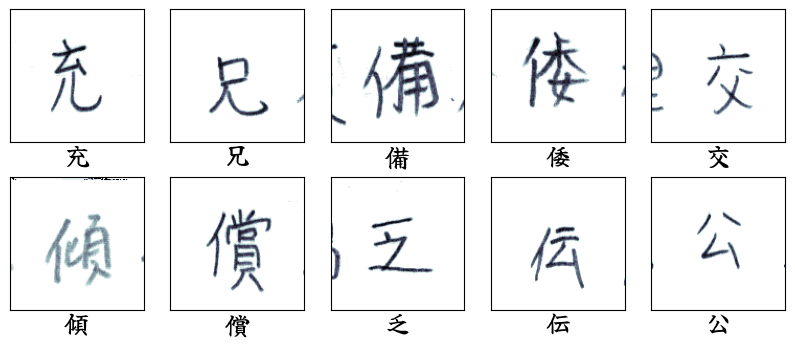

In [5]:
characters = batch[0]
print('Unscaled Data:')
print('min:', characters.min(), 'max:', characters.max())
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(characters[i], cmap=plt.cm.bone)
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])
plt.show()

## Preprocess data

In [6]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()

2023-07-13 12:53:38.231686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [45000]
	 [[{{node Placeholder/_4}}]]
2023-07-13 12:53:38.232038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [45000]
	 [[{{node Placeholder/_4}}]]


In [7]:
batch = scaled_iterator.next()

Scaled Data:
min: 0.05882353 max: 1.0


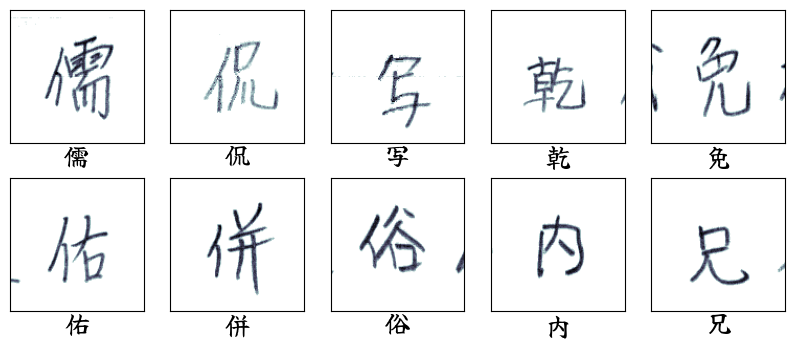

In [8]:
characters = batch[0]
print('Scaled Data:')
print('min:', characters.min(), 'max:', characters.max())
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(characters[i], cmap=plt.cm.bone)
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])
plt.show()

In [9]:
train_share = .7
val_share = .2
test_share = .1

In [10]:
train_size = int(len(data) * train_share)
val_size = int(len(data) * val_share)
test_size = int(len(data) * test_share)

In [11]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

## Define the model

In [12]:
model = keras.Sequential()

In [13]:
model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(127,128,1)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='sigmoid'))


In [14]:
model.compile('adam', tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0

## Train the model

In [15]:
logdir='logs'

In [16]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [17]:
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20


2023-07-13 12:53:38.755428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]
2023-07-13 12:53:38.755667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]
2023-07-13 12:53:40.256687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-13 12:53:41.092679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-1

984/984 [==============================] - ETA: 0s - loss: 5.4174 - accuracy: 0.0037

2023-07-13 12:53:52.104544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]
2023-07-13 12:53:52.104811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [45000]
	 [[{{node Placeholder/_4}}]]


984/984 [==============================] - 16s 11ms/step - loss: 5.4174 - accuracy: 0.0037 - val_loss: 5.4179 - val_accuracy: 0.0027
Epoch 2/20
984/984 [==============================] - 11s 11ms/step - loss: 5.4167 - accuracy: 0.0042 - val_loss: 5.4192 - val_accuracy: 0.0028
Epoch 3/20
984/984 [==============================] - 11s 11ms/step - loss: 5.4165 - accuracy: 0.0045 - val_loss: 5.4202 - val_accuracy: 0.0028
Epoch 4/20
984/984 [==============================] - 11s 11ms/step - loss: 5.4164 - accuracy: 0.0044 - val_loss: 5.4208 - val_accuracy: 0.0029
Epoch 5/20
599/984 [=================>............] - ETA: 3s - loss: 5.4161 - accuracy: 0.0044

## Run tests and export

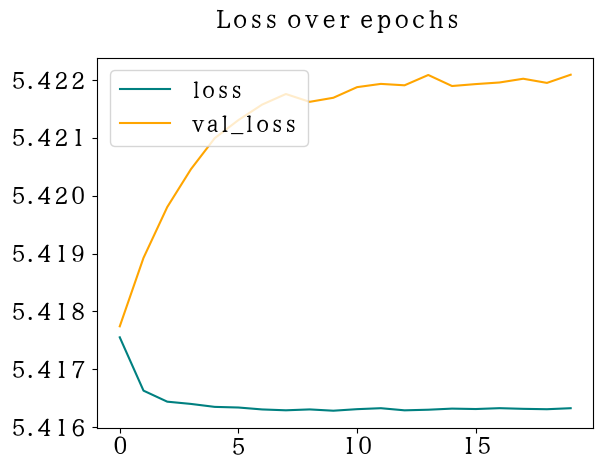

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss over epochs', fontsize=20)
plt.legend(loc="upper left")
plt.show()

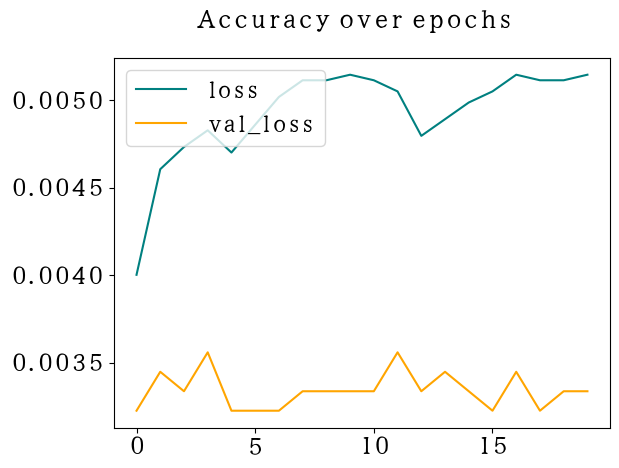

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy over epochs', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = keras.metrics.Precision()
re = keras.metrics.Recall()
acc = keras.metrics.CategoricalAccuracy()

In [ ]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-07-12 22:52:03.877674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]
2023-07-12 22:52:03.878005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [45000]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 16ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.003942358307540417, Recall: 0.26808035373687744, Accuracy: 0.0022321429569274187


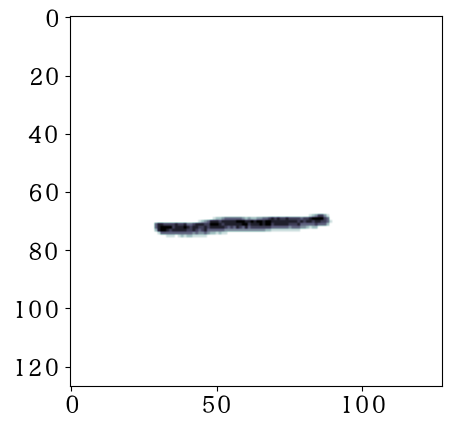

In [ ]:
img = cv2.imread('8G/一/000862.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap=plt.cm.bone)
plt.show()

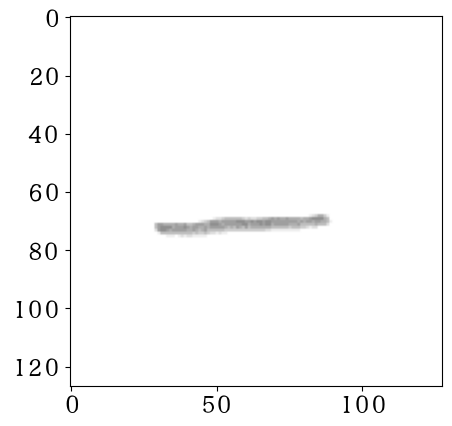

In [ ]:
resize = tf.image.resize(img, (127, 128))
plt.imshow(resize.numpy().astype(int), cmap=plt.cm.bone)
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(class_names[np.where(yhat == 1)[0][0]])

2023-07-12 23:00:37.980515: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : INTERNAL: Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(3760): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
2023-07-12 23:00:37.980569: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(3760): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node sequential_1/conv2d_3/Relu}}]]


InternalError: Graph execution error:

Detected at node 'sequential_1/conv2d_3/Relu' defined at (most recent call last):
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19971/1479965249.py", line 1, in <module>
      yhat = model.predict(np.expand_dims(resize/255, 0))
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_3/Relu'
Cudnn graph failed to build: UNKNOWN: CUDNN_STATUS_BAD_PARAM
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(3760): 'conv_op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node sequential_1/conv2d_3/Relu}}]] [Op:__inference_predict_function_202596]

In [ ]:
model.save(os.path.join('models', 'kanji-ocr-model.h5'))

In [ ]:
loaded_model = keras.models.load_model(os.path.join('models', 'kanji-ocr-model.h5'))
print(loaded_model)

In [ ]:
yhat_new = loaded_model.predict(np.expand_dims(resize/255, 0))
print(class_names[np.where(yhat_new == 1)[0][0]])

ValueError: in user code:

    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/notkali/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "conv2d_3" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 127, 128, 3)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 127, 128, 3), dtype=float32)
      • training=False
      • mask=None
